<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import fiona
import geopandas as gpd

fiona.drvsupport.supported_drivers['libkml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

# Bankhead National Forest - SQUIRE example

## Overview

The Surface Quantitative Precipitation Estimates (SQUIRE) value added product that has radar estimated rainfall rates from CSAPR2 interpolated to a two-dimensional Cartesian grid. These rainfall estimates can then be used to estimate rain accumulations. In this example, we show how to estimate the monthly accumulation over the CSAPR2 domain using SQUIRE.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README.html) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

## Current List of Supported Sites of Interest
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| M1    | 34.34525 | -87.33842 |
| S4    | 34.46451 | -87.23598 |
| S20   | 34.65401 | -87.29264 |
| S30   | 34.38501 | -86.92757 |
| S40   | 34.17932 | -87.45349 |
| S10   | 34.343611 | -87.350278 |

## Pending List of Supported Sites of Interest
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| S13    | 34.343889 | -87.350556 |
| S14    | 34.343333 | -87.350833 |

<img src="images/bnf-in-situ-locations.png" width=1500 alt="BNF Sensors"></img>

# Load all of the available SQUIRE data.

In [2]:
ds = xr.open_mfdataset('/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2squireS3.c1/*.nc')

## SQUIRE Dataset Description

The SQUIRE dataset provides several variables on a two-dimensional Cartesian grid for quantitative precipitation analysis.

Radar data from CSAPR2 are interpolated to this grid through the following steps:

 * Selecting radar gates at the lowest non-blocked elevation.

 * Applying the Barnes interpolation scheme (Barnes, 1964) with a radius of influence that varies by distance from the radar to account for beam spreading.

 * Mapping the interpolated values onto a 500 m-resolution 2-D grid.

Variables:

 * *rain_rate_A* — Rainfall rate derived from the CSAPR2 specific attenuation (k).

 * *rain_rate_Z* — Rainfall rate derived from the CSAPR2 attenuation-corrected reflectivity.

 * *corrected_reflectivity* — The attenuation-corrected reflectivity field from CSAPR2, obtained from the CMAC product.

 * *lowest_height* — The representative height (in meters) for the reflectivity and rainfall-rate estimates at each grid point. Because rainfall cannot be retrieved directly at the surface within radar volumes, this value indicates the altitude from which the rainfall rate is inferred. It provides context for assessing whether rainfall rates are representative of precipitation reaching the surface, as melting-layer enhancement may artificially increase reflectivity and estimated rates aloft.

# Reference

Barnes, S. L. (1964). A technique for maximizing details in numerical weather map analysis. Journal of Applied Meteorology, 3(4), 396–409. https://doi.org/10.1175/1520-0450(1964)003

In [3]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:                 (time: 17253, y: 171, x: 141)
Coordinates:
  * time                    (time) datetime64[ns] 138kB 2025-02-16T18:24:17 ....
  * y                       (y) float32 684B -6.5e+04 -6.45e+04 ... 2e+04
  * x                       (x) float32 564B -5e+04 -4.95e+04 ... 1.95e+04 2e+04
    lat                     (y, x) float32 96kB dask.array<chunksize=(171, 141), meta=np.ndarray>
    lon                     (y, x) float32 96kB dask.array<chunksize=(171, 141), meta=np.ndarray>
Data variables:
    base_time               (time) datetime64[ns] 138kB 2025-02-16 ... 2025-0...
    time_offset             (time) datetime64[ns] 138kB dask.array<chunksize=(27,), meta=np.ndarray>
    rain_rate_A             (time, y, x) float32 2GB dask.array<chunksize=(27, 171, 141), meta=np.ndarray>
    rain_rate_Z             (time, y, x) float32 2GB dask.array<chunksize=(27, 171, 141), meta=np.ndarray>
    rain_rate_combined      (time, y, x) float32 2GB dask.array<chunksize=(27, 171, 141), meta=np.ndarray>
    corrected_reflectivity  (time, y, x) float32 2GB dask.array<chunksize=(27, 171, 141), meta=np.ndarray>
    lowest_height           (time, y, x) float32 2GB dask.array<chunksize=(27, 171, 141), meta=np.ndarray>
    alt                     (time) float32 69kB 180.0 180.0 ... 180.0 180.0
Attributes: (12/13)
    command_line:          squire -s bnf -f S3 -b 20250216.000000 -e 20250217...
    Conventions:           ARM-1.3 Cf/Radial
    process_version:       vap-squire-0.0-0.dev0.dirty.el8
    dod_version:           csapr2squire-c1-1.1
    input_datastreams:     bnfcsapr2cmacS3.c1 : 0.0 : 20250216.182417-2025021...
    site_id:               bnf
    ...                    ...
    facility_id:           S3
    data_level:            c1
    location_description:  Southeast U.S. in Bankhead National Forest (BNF), ...
    datastream:            bnfcsapr2squireS3.c1
    doi:                   10.5439/2588229
    history:               created by user rjackson on machine cirrus1.ccs.or...

## Add functions for the scale bar.

In [4]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + np.atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

## Load the kmz files

In [5]:
# note: the KMZ file provided contains multiple geometry columns. 
in_layers = []
for layer in fiona.listlayers("locations/BNF.kmz"):
    print(layer)
    s = gpd.read_file("locations/BNF.kmz", layer=layer, engine='fiona')
    in_layers.append(s)

BNF_Schematic
M1
S10
S13
S14
S20
S30
S40
S3
S4
Original_Proclaimed_National_Forests_and_National_Grasslands_(Feature_Layer).kml
Original_Proclaimed_National_Forests_and_National_Grasslands__Feature_Layer_


## Plot the SQUIRE accumulation for a month of data.

/tmp/ipykernel_210/796744800.py:94: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


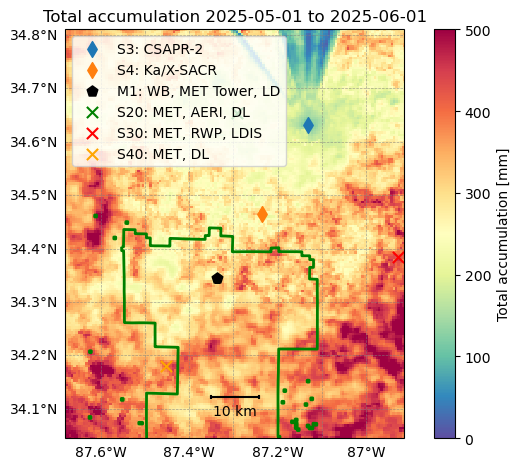

In [6]:
# Specify your start and end times here

start_time = '2025-05-01'
end_time = '2025-06-01'

# CSAPR2 PPIs are in 10 min timesteps, so the total accumulation is the sum of the rain rates divided by 6
dt = ds['time'].diff(dim='time').astype('timedelta64[s]')
total_accumulation = ds['rain_rate_combined'].where(ds['lowest_height'] < 2500.)
total = total_accumulation.sel(time=slice(start_time, end_time)).sum(dim='time', skipna=True)/6.

# Make the figure
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the mesh of accumulations
lat_grid = ds['lat'].values
lon_grid = ds['lon'].values
c = ax.pcolormesh(lon_grid, lat_grid, total.where(total > 10), vmin=0,
    vmax=500, cmap='Spectral_r')
ax.set_xlim([lon_grid.min(), lon_grid.max()])
ax.set_ylim([lat_grid.min(), lat_grid.max()])
plt.colorbar(c, label='Total accumulation [mm]')

# Add Grid lines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER            
# add in kmz file layers

# BNF Forest Preserve Land
in_layers[11].plot(transform=ccrs.PlateCarree(),
                   facecolor="none", 
                   edgecolor="green",
                   linewidth=2.0,
                   ax=ax,
                   label="BNF Forest Preserve",
                   zorder=2)
# CSAPR2 location
in_layers[8].plot(transform=ccrs.PlateCarree(),     
                  ax=ax, 
                  label="S3: CSAPR-2",
                  zorder=2,
                  marker="d",
                  markersize=65)
# X-SAPR location
in_layers[9].plot(transform=ccrs.PlateCarree(),     
                  ax=ax, 
                  label="S4: Ka/X-SACR",
                  zorder=2,
                  marker="d",
                  markersize=65)
# M1 location
in_layers[1].loc[[4], 'geometry'].plot(transform=ccrs.PlateCarree(),     
                                       ax=ax, 
                                       label="M1: WB, MET Tower, LD",
                                       zorder=2,
                                       marker="p",
                                       color="black",
                                       markersize=65)

# S20 location - MET, AERI, DL
in_layers[5].plot(transform=ccrs.PlateCarree(),     
                          ax=ax, 
                          label="S20: MET, AERI, DL",
                          zorder=2,
                          marker="x",
                          color="green",
                          markersize=65)

# S30 location - MET, RWP, LDIS
in_layers[6].plot(transform=ccrs.PlateCarree(),     
                          ax=ax, 
                          label="S30: MET, RWP, LDIS",
                          zorder=2,
                          marker="x",
                          color="red",
                          markersize=65)

# S40 location - MET, AERI, DL
in_layers[7].plot(transform=ccrs.PlateCarree(),     
                          ax=ax, 
                          label="S40: MET, DL",
                          zorder=2,
                          marker="x",
                          color="orange",
                          markersize=65)

# Plot the scale bar
add_scale_line(10, ax, projection=ccrs.PlateCarree())

                                                        
ax.set_title(f'Total accumulation {start_time} to {end_time}')
ax.legend()
fig.tight_layout()
plt.savefig('squire_May2025.png')